# PAE Analysis Notebook

This notebook analyzes the relationships between residues in a protein using various metrics derived from AlphaFold's predicted aligned error (PAE) matrices. Each section explains the analysis method and its biological significance.

## Import Libraries and Load Data

We begin by importing the necessary libraries and loading the PAE matrices from the pickle files. These matrices represent the predicted alignment errors between residues in the protein structure.

In [ ]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import networkx as nx

enzymes = ["transthyretin_f2c07", "transthyretin_d0a39"]

# Find all pickle files within the enzyme's pickle directory
pickle_files = glob.glob("transthyretin_f2c07/pickle/*.pickle")

print(f"Found {len(pickle_files)} pickle files.")

keys: ['transthyretin_f2c07', 'transthyretin_d0a39']
Found 5 pickle files.


## Standard Deviation Analysis

The standard deviation (std. dev.) is calculated across the PAE matrices to quantify the variability in the predicted alignment errors for each residue pair. High std. dev. values indicate regions with significant variability, while low values suggest consistent predictions.

Maximum variability between residues 244 and 116: 5.711
Residue with most variable interactions: 244 (sum std dev = 1485.000)


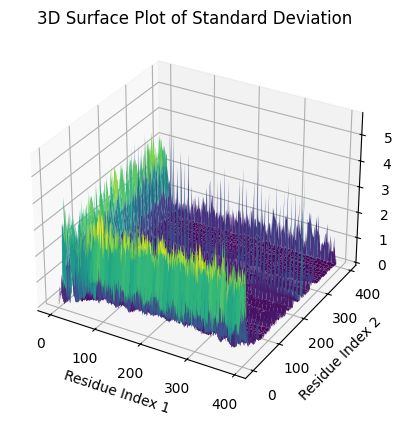

In [10]:
matrices = []
for fname in pickle_files:
    with open(fname, "rb") as f:
        data = pickle.load(f)
        key = None
        if 'predicted_aligned_error' in data:
            key = 'predicted_aligned_error'
        elif 'pae' in data:
            key = 'pae'
        else:
            raise KeyError(f"No PAE matrix found in {fname}")
        matrices.append(np.array(data[key]))

stack = np.stack(matrices)

std_dev = np.std(stack, axis=0)
max_idx = np.unravel_index(np.argmax(std_dev), std_dev.shape)
print(f"Maximum variability between residues {max_idx[0]} and {max_idx[1]}: {std_dev[max_idx]:.3f}")

# To see which single residue is most variable overall
residue_variability = np.sum(std_dev, axis=1)
most_variable_residue = np.argmax(residue_variability)
print(f"Residue with most variable interactions: {most_variable_residue} (sum std dev = {residue_variability[most_variable_residue]:.3f})")

# Create a 3D surface plot for the standard deviation matrix
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(std_dev.shape[0])
y = np.arange(std_dev.shape[1])
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, std_dev, cmap='viridis')
ax.set_title('3D Surface Plot of Standard Deviation')
ax.set_xlabel('Residue Index 1')
ax.set_ylabel('Residue Index 2')
ax.set_zlabel('Standard Deviation')

plt.show()

## 3D Surface Plot of Standard Deviation

A 3D surface plot is created to visualize the standard deviation matrix. This provides a clear view of the variability across residue pairs in three dimensions.

## Mean Matrix Analysis

The mean matrix is calculated to determine the average predicted alignment error across all models for each residue pair. This highlights regions with consistently low or high alignment errors.

__What It Shows__: The average predicted alignment error across all models for each residue pair.\
__Purpose__: Highlights regions with consistently low or high alignment errors, indicating stable or uncertain interactions.


In [21]:
# 1. Mean Matrix
mean_matrix = np.mean(stack, axis=0)
np.save("mean_matrix.npy", mean_matrix)

## Correlation Matrix Analysis

The correlation matrix is computed to identify relationships between the alignment errors of different residue pairs. This helps in understanding coordinated variability patterns.

__What It Shows__: The correlation between the alignment errors of different residue pairs.\
__Purpose__: Identifies residues that exhibit similar variability patterns, which might indicate coordinated movement or functional relationships.

In [22]:
# 2. Correlation Matrix
correlation_matrix = np.corrcoef(stack.reshape(stack.shape[0], -1))
np.save("correlation_matrix.npy", correlation_matrix)

## Residue Interaction Heatmap

A heatmap is generated to visualize the average alignment error for each residue pair. This provides an intuitive representation of interaction strengths or variability.

__What It Shows__: A heatmap of the average or maximum alignment error for each residue pair.\
__Purpose__: Visualizes the interaction strength or variability between residues.

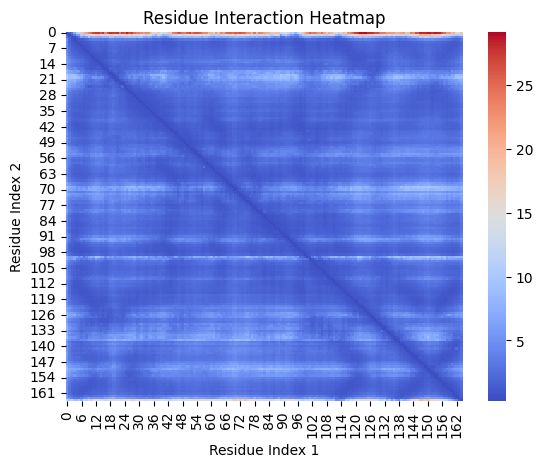

In [23]:
# 3. Residue Interaction Heatmap
sns.heatmap(mean_matrix, cmap='coolwarm')
plt.title('Residue Interaction Heatmap')
plt.xlabel('Residue Index 1')
plt.ylabel('Residue Index 2')
plt.show()

## Principal Component Analysis (PCA)

PCA is applied to reduce the dimensionality of the data and identify dominant patterns of variability in the alignment errors. This helps in understanding the major sources of variability in the PAE matrices.

__What It Shows__: The principal components of the variability in the alignment errors.\
__Purpose__: Reduces the dimensionality of the data to identify dominant patterns of variability.

In [24]:
# 4. Principal Component Analysis (PCA)
reshaped_stack = stack.reshape(stack.shape[0], -1)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(reshaped_stack)
print("Principal Components:", principal_components)

Principal Components: [[-31.09144056 -37.23985377]
 [-10.19360889 -25.63826749]
 [-14.8327466   28.86424387]
 [-25.78890924  35.07121255]
 [ 81.9067053   -1.05733516]]


## Clustering Analysis

Clustering is performed to group residues based on their alignment error patterns. This helps in identifying clusters of residues that may share functional or structural roles.

__What It Shows__: Groups of residues with similar alignment error patterns.\
__Purpose__: Identifies clusters of residues that may work together or share functional roles.

In [25]:
# 5. Clustering Analysis
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(reshaped_stack)
print("Cluster Labels:", clusters)

Cluster Labels: [1 2 0 0 2]


## Maximum Variability Residues

The residue pairs with the highest variability in alignment errors are identified. This highlights regions of the protein that are most uncertain or flexible.

__What It Shows__: Residues with the highest variability in alignment errors.\
__Purpose__: Pinpoints regions of the protein that are most uncertain or flexible.

In [26]:
# 6. Maximum Variability Residues
max_variability = np.max(stack, axis=0)
np.save("max_variability.npy", max_variability)

## Contact Map Analysis

A contact map is generated to identify residue pairs that are likely to interact physically based on a distance threshold. This provides insights into the structural organization of the protein.

__What It Shows__: A binary map indicating whether residues are in contact based on a distance threshold.
__Purpose__: Identifies residue pairs that are likely to interact physically.

In [27]:
# 7. Contact Map Analysis
threshold = 5  # Adjust threshold as needed
contact_map = (mean_matrix < threshold).astype(int)
np.save("contact_map.npy", contact_map)

## Entropy Analysis

Entropy is calculated to measure the uncertainty in the alignment errors for each residue pair. High entropy indicates regions with significant variability, while low entropy suggests consistent predictions.

__What It Shows__: The entropy of the alignment errors for each residue pair.\
__Purpose__: Measures the uncertainty in the predictions for each pair.

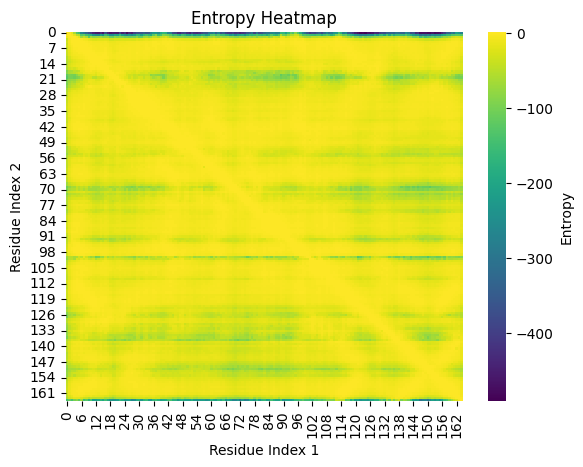

High-Entropy Residue Pairs: [[  0   0]
 [  0   1]
 [  1   1]
 ...
 [163 163]
 [163 164]
 [164 164]]
Residue with highest uncertainty: 98, Total Entropy: -540.000
Correlation between entropy and std. deviation: -0.564


In [28]:
# 8. Entropy Analysis
entropy = -np.sum(stack * np.log(stack + 1e-9), axis=0)
np.save("entropy.npy", entropy)

# Visualize the Entropy Matrix
sns.heatmap(entropy, cmap='viridis', cbar_kws={'label': 'Entropy'})
plt.title('Entropy Heatmap')
plt.xlabel('Residue Index 1')
plt.ylabel('Residue Index 2')
plt.show()

# Identify High-Entropy Regions
high_entropy_threshold = np.percentile(entropy, 90)  # Top 10% entropy values
high_entropy_indices = np.argwhere(entropy > high_entropy_threshold)
print("High-Entropy Residue Pairs:", high_entropy_indices)

# Summarize Residue-Wise Entropy
residue_entropy = np.sum(entropy, axis=1)
most_uncertain_residue = np.argmax(residue_entropy)
print(f"Residue with highest uncertainty: {most_uncertain_residue}, Total Entropy: {residue_entropy[most_uncertain_residue]:.3f}")

# Compare with Other Metrics
correlation_with_std = np.corrcoef(entropy.flatten(), std_dev.flatten())[0, 1]
print(f"Correlation between entropy and std. deviation: {correlation_with_std:.3f}")

# Save Results
np.savetxt("high_entropy_residues.txt", high_entropy_indices, fmt='%d')

## Network Analysis

A graph representation of residue interactions is created, where nodes represent residues and edges represent interactions based on the mean alignment error. This helps in visualizing the connectivity and interaction patterns within the protein.

__What It Shows__: A graph representation of residue interactions.\
__Purpose__: Models the protein as a network, where nodes are residues and edges represent interactions.

In [29]:
# 9. Network Analysis
G = nx.Graph()
for i in range(mean_matrix.shape[0]):
    for j in range(mean_matrix.shape[1]):
        if mean_matrix[i, j] < threshold:
            G.add_edge(i, j, weight=mean_matrix[i, j])
print("Network Graph:", G)

Network Graph: Graph with 165 nodes and 13245 edges


### Why Are There 5 Pickle Files (Matrices)?

The presence of 5 pickle files corresponds to the multiple models generated by AlphaFold during its prediction process. AlphaFold typically generates several models to account for variability and uncertainty in its predictions. Here's why:

1. **Multiple Models for Robust Predictions:**
   - AlphaFold uses an ensemble of models to predict the protein structure. Each model may have slight variations in its architecture or training parameters.
   - These variations allow AlphaFold to explore different conformational possibilities for the protein, leading to a more comprehensive understanding of its structure.

2. **Differences Between the Files:**
   - Each pickle file represents the output of a different AlphaFold model.
   - The differences between the files lie in the predicted values (e.g., PAE matrices, confidence scores, etc.) due to the inherent variability in the models.
   - These differences are crucial for identifying regions of the protein where the predictions are consistent (high confidence) or variable (low confidence).

3. **Are They PAE Values?**
   - Yes, the matrices in the pickle files likely contain PAE (Predicted Aligned Error) values or similar metrics.
   - The PAE matrix is a key output of AlphaFold, representing the expected positional error in aligning residues. It is used to assess the confidence in the predicted structure.

---

### How to Interpret the Differences
1. **Consistency Across Models:**
   - If the PAE values are consistent across the 5 models, it indicates high confidence in the predicted structure for those regions.
   - Consistency is often observed in well-folded, stable regions of the protein.

2. **Variability Across Models:**
   - Variability in the PAE values suggests uncertainty in the structural alignment for those regions.
   - This could correspond to flexible loops, disordered regions, or areas with multiple conformations.

---

### Why Use Multiple Models?
1. **Capturing Structural Flexibility:**
   - Proteins are dynamic molecules, and their structures can adopt multiple conformations. Multiple models help capture this flexibility.

2. **Improving Prediction Accuracy:**
   - By averaging or analyzing the outputs of multiple models, AlphaFold can provide a more accurate and reliable prediction.

3. **Quantifying Uncertainty:**
   - The variability between models provides a measure of uncertainty, which is critical for interpreting the predictions.

---

In summary, the 5 pickle files represent the outputs of different AlphaFold models, each contributing to a comprehensive understanding of the protein's structure. The matrices likely contain PAE values, which are used to assess the confidence and variability in the predictions.

### How AlphaFold Generates 3D Matrices and Their Meaning

AlphaFold is a deep learning-based system designed to predict protein structures with high accuracy. It uses multiple sequence alignments (MSAs) and other structural information to generate predictions. Here's how the 3D matrices and their components are derived:

#### 1. **Predicted Aligned Error (PAE) Matrix:**
   - **What It Represents:** The PAE matrix is a 2D matrix where each element (i, j) represents the expected positional error in aligning residue `i` with residue `j` in the predicted structure.
   - **How It's Generated:**
     - AlphaFold predicts the 3D coordinates of all residues in a protein.
     - It then estimates the uncertainty in the relative positions of residues, resulting in the PAE matrix.
   - **Interpretation:**
     - Low values in the PAE matrix indicate high confidence in the relative positions of residues.
     - High values suggest uncertainty or flexibility in the alignment.

#### 2. **Residues in the Context of Proteins:**
   - **Definition:** Residues are the individual building blocks of a protein, derived from amino acids. Each residue corresponds to a specific amino acid in the protein sequence.
   - **Role in Structure:** Residues interact with each other to form the protein's secondary, tertiary, and quaternary structures. These interactions are critical for the protein's function.

#### 3. **Standard Deviation in the PAE Matrix:**
   - **What It Measures:** The standard deviation (std. dev.) across multiple PAE matrices (from different AlphaFold models) quantifies the variability in the predicted alignment errors for each residue pair.
   - **Significance:**
     - **High Std. Dev.:** Indicates variability in the predicted alignment errors, suggesting that the interaction between the residues is uncertain or flexible. This could correspond to regions of the protein that are disordered or have multiple conformations.
     - **Low Std. Dev.:** Suggests consistent predictions across models, indicating stable and reliable interactions between residues.


---

### Biological Implications of Std. Deviation for Residue Activity
The std. dev. in the PAE matrix can provide insights into the functional and structural dynamics of the protein:

1. **High Variability Regions:**
   - These regions might correspond to:
     - Flexible loops or disordered regions.
     - Binding sites that adapt to different ligands.
     - Regions involved in conformational changes during activity.
   - **Activity Implication:** High variability could indicate regions critical for dynamic functions, such as enzyme catalysis or molecular recognition.

2. **Low Variability Regions:**
   - These are likely to be:
     - Core structural elements (e.g., alpha-helices, beta-sheets).
     - Stable domains that maintain the protein's integrity.
   - **Activity Implication:** Low variability suggests structural stability, which is essential for maintaining the protein's overall shape and function.


---

### Research Applications
1. **Drug Design:**
   - Identifying regions with high variability can help target flexible binding sites for drug molecules.
   - Stable regions can be used to design inhibitors that lock the protein in a specific conformation.

2. **Protein Engineering:**
   - Understanding residue variability can guide mutations to enhance stability or introduce flexibility for desired functions.

3. **Functional Annotation:**
   - Variability patterns can help infer the functional roles of different regions in the protein.

In summary, the std. dev. in the PAE matrix provides a quantitative measure of the confidence and variability in AlphaFold's predictions, offering valuable insights into the protein's structural and functional dynamics. Let me know if you'd like further clarification or assistance!

### Explanation of Standard Deviation in the Context of AlphaFold

In the context of AlphaFold, the standard deviation (std. dev.) of the predicted aligned error (PAE) matrix provides insights into the variability or uncertainty in the predicted structural alignment between residues across different models or predictions.

1. **Predicted Aligned Error (PAE):**
   - PAE is a measure of the expected positional error in the alignment of two residues in the predicted structure.
   - A lower PAE value indicates higher confidence in the alignment, while a higher value suggests uncertainty.

2. **Standard Deviation of PAE:**
   - By calculating the std. dev. across multiple models, we can identify regions of the protein structure where the predictions are inconsistent.
   - High std. dev. values indicate regions with significant variability, suggesting that these regions are less reliable or more flexible.
   - Low std. dev. values indicate consistent predictions, implying higher confidence in the structural alignment.

3. **Biological Implications:**
   - Regions with high variability might correspond to flexible loops, disordered regions, or areas with intrinsic structural ambiguity.
   - Consistent regions are likely to be well-folded and stable, such as secondary structure elements (e.g., alpha-helices, beta-sheets).